In [1]:
import pandas as pd
from pulp import *
import numpy as np
np.random.seed(0)

## Parameters

### Inbound Costs

In [2]:
# Inbound Costs
df_inbound = pd.read_csv(r"F:/NYIT/DTSC-615_Optimazition for Data Science/Project/df_inprice.csv", index_col = 0)
df_inbound.head()

,FROM,D1,D2
0,P1,3.0,5.0
1,P2,2.3,6.6


### Outbound Costs

In [3]:
# Outbound Costs
df_outbound = pd.read_csv(r"F:/NYIT/DTSC-615_Optimazition for Data Science/Project/df_outprice.csv", index_col = 0)
df_outbound

,from,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S191,S192,S193,S194,S195,S196,S197,S198,S199,S200
0,D1,2.30,4.23,2.26,3.38,1.59,2.01,5.32,6.63,2.38,...,5.86,8.30,3.02,1.01,2.77,2.96,3.53,8.60,2.77,7.06
1,D2,5.31,2.18,8.52,8.34,4.59,1.04,1.89,6.45,8.35,...,7.54,2.11,4.33,1.54,4.75,7.84,8.21,4.51,3.27,3.13


In [4]:
# Mering DataFrame
df_melt = pd.melt(df_outbound.set_index('from').T.reset_index(), id_vars=['index'], value_vars=['D1', 'D2'])
print("{:,} records".format(len(df_melt)))
df_melt.head()

400 records


,index,from,value
0,S1,D1,2.30
1,S2,D1,4.23
2,S3,D1,2.26
3,S4,D1,3.38
4,S5,D1,1.59


In [5]:
df1 = df_melt.copy()

In [6]:
df2 = pd.DataFrame(df1.groupby(by = ['index','from','value']).sum().reset_index())
df2 = df2.sort_values(['value'],ascending=False)
df2 = df2[:5]
df2

,index,from,value
101,S144,D2,8.76
193,S186,D2,8.73
181,S180,D2,8.73
364,S83,D1,8.72
16,S106,D1,8.70


### Plot Outbound Transportation Costs BoxPlot

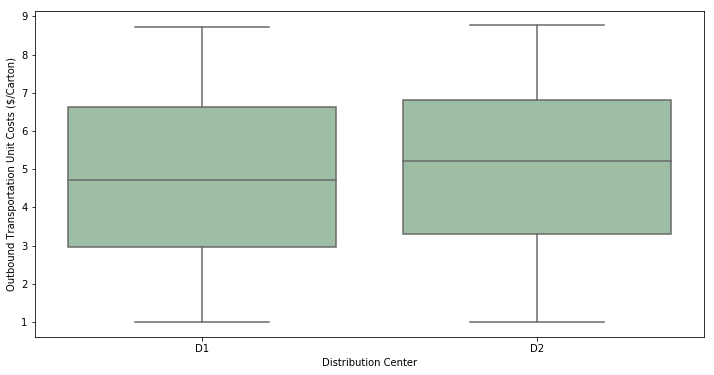

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='from', y='value', data=df_melt, color='#99c2a2')
# ax = sns.swarmplot(x="from", y="value", data=df_melt, color='#7d0013')
plt.xlabel('Distribution Center')
plt.ylabel('Outbound Transportation Unit Costs ($/Carton)')
plt.show()

### Production Plant Capacity

In [9]:
# Production capacity
df_prod = pd.DataFrame({
    'plant': ['P1','P2'],
    'max': [200, 300],
})[['plant', 'max']]
df_prod

,plant,max
0,P1,200
1,P2,300


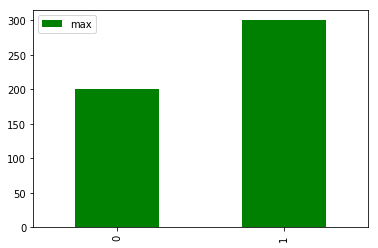

In [20]:
df_prod.plot(kind='bar',color=['green'])

In [10]:
# Cross-Docking Capacity
df_t = pd.DataFrame({
    'DC': ['D1','D2'],
    'CAPACITY': [450, 300]
})[['DC', 'CAPACITY']]
df_t

,DC,CAPACITY
0,D1,450
1,D2,300


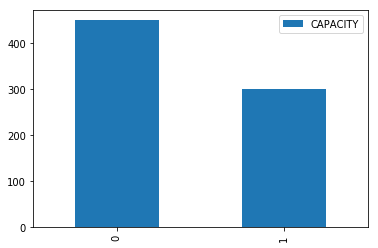

In [25]:
df_t.plot(kind='bar')

### Demand Data

In [11]:
# Demand
df_demand = pd.read_csv(r"F:/NYIT/DTSC-615_Optimazition for Data Science/Project/df_demand.csv", index_col = 0)
print("{:,} total demand".format(df_demand.DEMAND.sum()))
df_demand.head()

31,806 total demand


,STORE,DEMAND
0,D1,244
1,D2,172
2,D3,124
3,D4,90
4,D5,158


### Build the Optimization Model

In [12]:
# 1. Initiliaze Class
model = LpProblem("Transhipment_Problem", LpMinimize)

# 2. Define Decision Variables
# Inbound Flows
I = LpVariable.dicts("I", [(i+1,j+1) for i in range(2) for j in range(2)],
                     lowBound=0, upBound=None, cat='Integer') # I(i,j) from plant i for platform j
# Outbound Flows
O = LpVariable.dicts("O", [(i+1,j+1) for i in range(2) for j in range(200)],
                     lowBound=0, upBound=None, cat='Integer') # O(i,j) from platform i for customer j

# 3. Define Objective Function
# Total Transportation Cost
model += lpSum([df_inbound.iloc[i,j+1] * I[i+1,j+1] for i in range(2) for j in range(2)]) + lpSum([df_outbound.iloc[i,j+1] * O[i+1,j+1] for i in range(2) for j in range(200)]) 


# 4. Define Constraints
# Max capacity for plants
# for i in range(5):
#     model += lpSum([I[i+1, j+1] for j in range(2)]) <= df_prod.loc[i,'max']
# Shipment from DCs higher than demand per store
for j in range(200):
    model += lpSum([O[i+1, j+1] for i in range(2)]) >= df_demand.loc[j,'DEMAND']
# Conservation of the flow in the local DC (X-Docking Platform)
for p in range(2):
    model += lpSum([I[i+1, p+1] for i in range(2)]) == lpSum([O[p+1, j+1] for j in range(200)])
# Maximum Inbound Capacity in Platform i
# for p in range(2):
#     model += lpSum([I[i+1, p+1] for i in range(5)]) <= df_t.loc[p,'capacity']

# Solve Model
status = model.solve()
print(LpStatus[status])
print("Objective: z* = {}".format(
    value(model.objective)))

# Matrix result
inbound, outbound = np.zeros([2,2]), np.zeros([2,200])
for i in range(2):
    for j in range(2):
#         print(I[i+1, j+1].varValue, I[i+1, j+1].name)
        inbound[i, j] = I[i+1, j+1].varValue
for i in range(2):
    for j in range(200):
#         print(O[i+1, j+1].varValue, O[i+1, j+1].name)
        outbound[i, j] = O[i+1, j+1].varValue

Optimal
Objective: z* = 217189.3199999999


### Result

In [13]:
# Inbound flow
df_resin = pd.DataFrame(data = inbound, index =['P' + str(i+1) for i in range(2)], 
                        columns = ['D' + str(i+1) for i in range(2)]).astype(int)
df_resin.to_csv('df_inbound_flow.csv')
df_resin

,D1,D2
P1,0,6232
P2,25574,0


In [14]:
# Outbound flow
df_resout = pd.DataFrame(data = outbound, index =['D' + str(i+1) for i in range(2)], 
                        columns = ['S' + str(i+1) for i in range(200)])
df_resout.T

,D1,D2
S1,244.0,0.0
S2,172.0,0.0
S3,124.0,0.0
S4,90.0,0.0
S5,158.0,0.0
S6,175.0,0.0
S7,0.0,269.0
S8,223.0,0.0
S9,123.0,0.0
S10,0.0,129.0
